# Logistic Regression Background

* Logistic regression is a statistical model used for **binary classification problems** (two outputs), where the goal is to predict the probability that an observation belongs to one of two classes (e.g., 0 or 1, negative or positive).

* Unlike linear regression, which predicts continuous values, logistic regression outputs values between 0 and 1, interpretable as probabilities.

* The key idea is to model the log-odds (logit) as a linear function of the input features, then transform it to a probability using the sigmoid function.

* Given an input feature $x$, it is transformed to a probability score using the **sigmoid** function
$$\sigma(x)=\frac{1}{1+e^{-x}}$$

* As $x\to\infty$, $\sigma\to 1$.
* As $x\to-\infty$, $\sigma\to 0$.
* At $x=0, \sigma=\frac{1}{2}$.

# The Model

* Given input features $\mathbf{x}=\left[x_{1}\;x_{2}\ldots x_{n}\right]^{\intercal}$ and the weight vector $\mathbf{w}=\left[w_{1}\;w_{2}\ldots w_{n}\right]^{\intercal}$, as with linear regression, we find
$$z=\mathbf{w}^{\intercal}\mathbf{x}+b$$,
where $b$ is the bias term.

* To transform $z$ to a probability score, we apply
$$\widehat{y}=\sigma(z)=\frac{1}{1+e^{-z}}$$

# A Simple Binary Classification Problem

In [3]:
# Importing the dataset

import pandas as pd

df = pd.read_csv('binary_classification_dataset.csv')
df.head()

,feature1,feature2,label
0,2.614438,2.355516,1
1,2.996756,1.725742,1
2,-2.964490,-1.889220,0
3,2.645604,2.012787,1
4,-2.453810,-2.853352,0


In [4]:
# Defining the features and predictor variables

X = df[['feature1', 'feature2']].values
y = df['label'].values

In [5]:
# Splitting the dataset into training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
# Scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add bias term
X_train_bias = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_bias = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

In [8]:
# Training the model

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.0000

Confusion Matrix:
[[100   0]
 [  0 100]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [14]:
# Model Coefficients

print("\nCoefficients:", model.coef_)
print("Intercept:", model.intercept_)


Coefficients: [[1.9651045  1.81657679]]
Intercept: [-0.06664458]


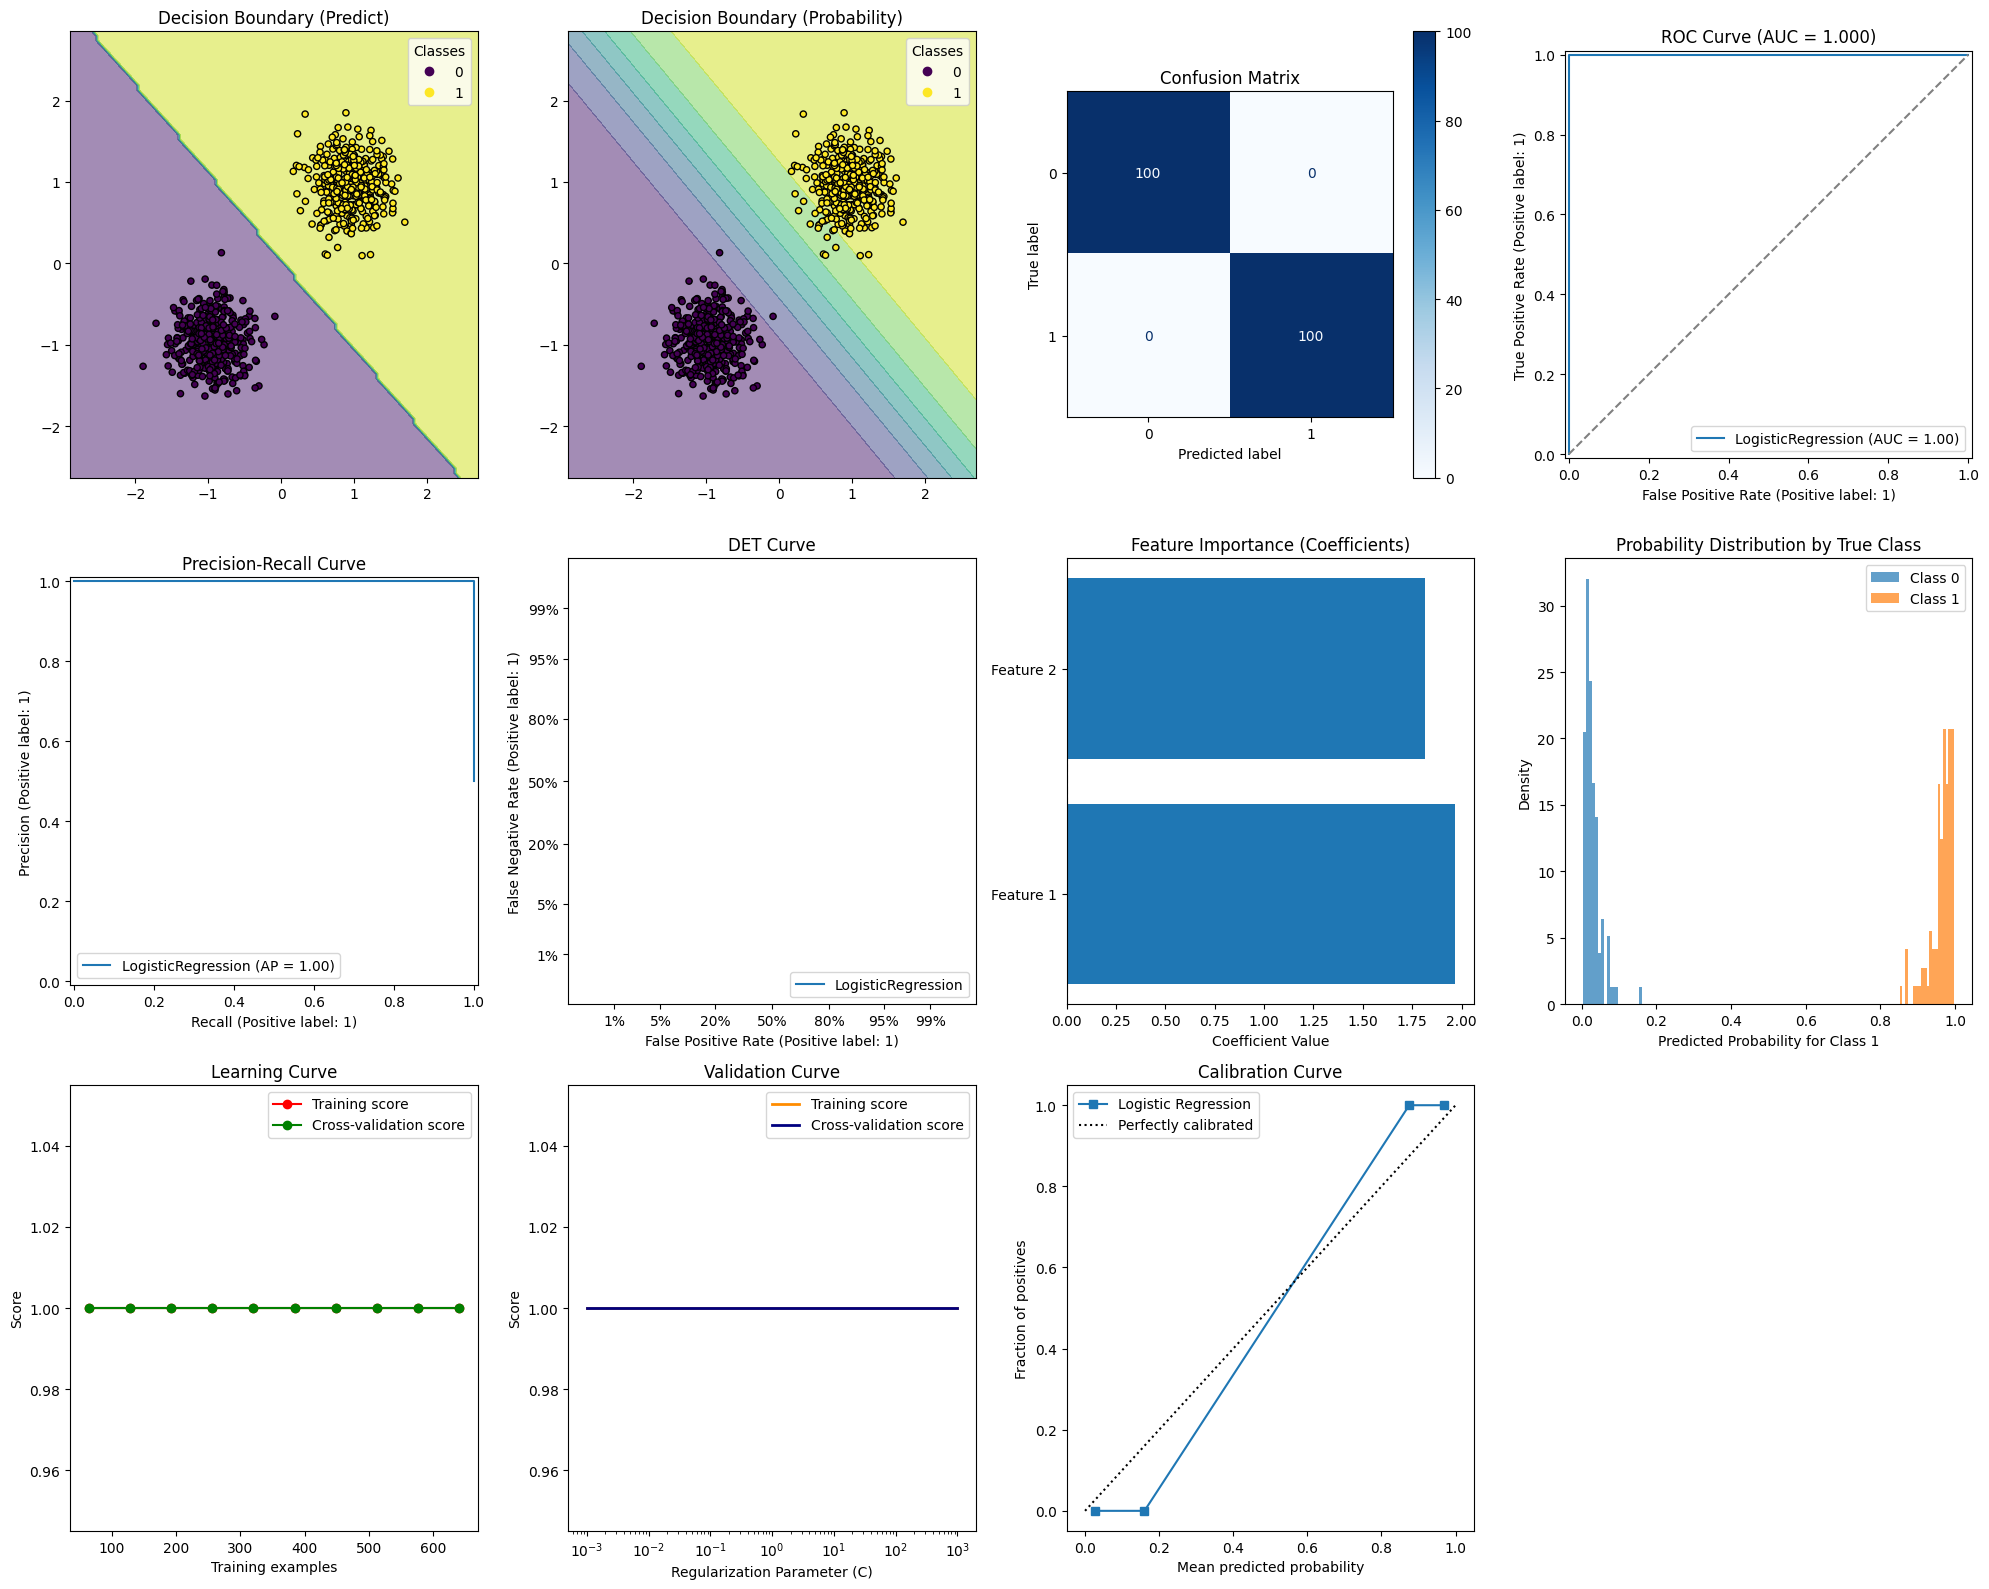

In [16]:
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve,
                             ConfusionMatrixDisplay, RocCurveDisplay,
                             PrecisionRecallDisplay, DetCurveDisplay)
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.calibration import calibration_curve

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# Get probabilities for positive class (class 1)
y_pred_proba_positive = model.predict_proba(X_test_scaled)[:, 1]

# 2. Decision Boundary Visualization
ax1 = plt.subplot(3, 4, 1)
DecisionBoundaryDisplay.from_estimator(
    model, X_train_scaled, response_method="predict",
    alpha=0.5, ax=ax1
)
scatter = ax1.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train,
                     edgecolors='k', s=20)
ax1.set_title('Decision Boundary (Predict)')
ax1.legend(*scatter.legend_elements(), title="Classes")

# 3. Decision Boundary with Probability
ax2 = plt.subplot(3, 4, 2)
DecisionBoundaryDisplay.from_estimator(
    model, X_train_scaled, response_method="predict_proba",
    alpha=0.5, ax=ax2
)
scatter = ax2.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train,
                     edgecolors='k', s=20)
ax2.set_title('Decision Boundary (Probability)')
ax2.legend(*scatter.legend_elements(), title="Classes")

# 4. Confusion Matrix
ax3 = plt.subplot(3, 4, 3)
ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, ax=ax3, cmap='Blues')
ax3.set_title('Confusion Matrix')

# 5. ROC Curve - FIXED
ax4 = plt.subplot(3, 4, 4)
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, ax=ax4)
ax4.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Calculate AUC properly
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_positive)
roc_auc = auc(fpr, tpr)
ax4.set_title(f'ROC Curve (AUC = {roc_auc:.3f})')

# 6. Precision-Recall Curve
ax5 = plt.subplot(3, 4, 5)
PrecisionRecallDisplay.from_estimator(model, X_test_scaled, y_test, ax=ax5)
ax5.set_title('Precision-Recall Curve')

# 7. DET Curve
ax6 = plt.subplot(3, 4, 6)
DetCurveDisplay.from_estimator(model, X_test_scaled, y_test, ax=ax6)
ax6.set_title('DET Curve')

# 8. Feature Importance (Coefficients)
ax7 = plt.subplot(3, 4, 7)
feature_names = [f'Feature {i+1}' for i in range(X.shape[1])]
coefficients = model.coef_[0]
y_pos = np.arange(len(coefficients))
ax7.barh(y_pos, coefficients)
ax7.set_yticks(y_pos)
ax7.set_yticklabels(feature_names)
ax7.set_xlabel('Coefficient Value')
ax7.set_title('Feature Importance (Coefficients)')
ax7.axvline(x=0, color='gray', linestyle='--')

# 9. Probability Distribution
ax8 = plt.subplot(3, 4, 8)
probabilities = model.predict_proba(X_test_scaled)
ax8.hist(probabilities[y_test == 0][:, 1], bins=20, alpha=0.7, label='Class 0', density=True)
ax8.hist(probabilities[y_test == 1][:, 1], bins=20, alpha=0.7, label='Class 1', density=True)
ax8.set_xlabel('Predicted Probability for Class 1')
ax8.set_ylabel('Density')
ax8.set_title('Probability Distribution by True Class')
ax8.legend()

# 10. Learning Curve
ax9 = plt.subplot(3, 4, 9)
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

ax9.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax9.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax9.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax9.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax9.set_xlabel('Training examples')
ax9.set_ylabel('Score')
ax9.set_title('Learning Curve')
ax9.legend(loc="best")

# 11. Validation Curve (Regularization parameter)
ax10 = plt.subplot(3, 4, 10)
param_range = np.logspace(-3, 3, 10)
train_scores, test_scores = validation_curve(
    model, X_train_scaled, y_train, param_name="C", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

ax10.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=2)
ax10.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="darkorange", lw=2)
ax10.semilogx(param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=2)
ax10.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="navy", lw=2)
ax10.set_xlabel('Regularization Parameter (C)')
ax10.set_ylabel('Score')
ax10.set_title('Validation Curve')
ax10.legend(loc="best")

# 12. Calibration Curve (Reliability Diagram)
ax11 = plt.subplot(3, 4, 11)
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba_positive, n_bins=10)
ax11.plot(mean_predicted_value, fraction_of_positives, "s-", label="Logistic Regression")
ax11.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax11.set_xlabel('Mean predicted probability')
ax11.set_ylabel('Fraction of positives')
ax11.set_title('Calibration Curve')
ax11.legend()

plt.tight_layout()
plt.show()